# Local Averages

In [1]:
import numpy as np
import scipy as sp
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

import sys
sys.path.append("../../")
import pyApproxTools as pat
importlib.reload(pat)

%matplotlib inline

## Local Averages

Now we are interested in local averages - where we integrate $v(x)$ against some compactly supported molifier function $\varphi_\varepsilon$, that is we find $\int \varphi_{\varepsilon}(x - x_0) v(x) \, \mathrm{d} x$. We find a Riesz representer $\omega_{x_0, \varepsilon}$ of this local integration, that is we define
$$
\langle \omega_{x_0, \varepsilon}, v \rangle = \int \varphi_{\varepsilon}(x - x_0) v(x) \, \mathrm{d} x 
$$

In the case where $\varphi_{\varepsilon} = \mathbb{1}_{[x_0 - \varepsilon/2, x_0 + \varepsilon/2]}$, and our space is $H_0^1([0,1])$, we have that
$$
\omega_{x_0, \varepsilon}(x) = \frac{1}{\sqrt{x_0-\varepsilon/6 + x_0^2}}
\begin{cases}
(1-x_0) x & \text{for } x \le x_0-\varepsilon/2 \\
(1-x_0) x - \frac{1}{2}\frac{(x-(x_0-\varepsilon/2))^2}{\epsilon} & \text{for } x_0 - \varepsilon/2 < x \le x_0+\varepsilon/2 \\
x_0 (1 - x)  & \text{for } x > x_0 + \varepsilon/2
\end{cases}
$$


### Projections

First we just want to see the performance of the projection on to a basis of uniformly spaced local averages for $m\to\infty$ with a variety of $\varepsilon$. We test this against a single function that is made up of sinusoids with random coefficients, i.e.
$$
v(x) = \sum_{k=1}^N \frac{y_k}{1+k^2}\sin(k \pi x)
$$
where $y_k\sim \mathcal{U}([-1,1])$ are IID uniformly distributed.

We then produce, for a variety of $\varepsilon$ (from about $1\times 10^{-2}$ to $1\times 10^{-4}$) a series of evenly spaced local averages as our basis, i.e. we take
$$
W_m = \mathrm{span}\{ \omega_{x_k, \varepsilon} : x_k = \varepsilon/2 + k / m \text{ for } k=0\ldots m-1 \}
$$
for $m$ ranging from 10 to something higher. Note that this allows the local averages to overlap.

We then plot $\| v - P_{W_m} v \|_{H_0^1}$ against $m$ for each choice of $\varepsilon$.

In [3]:
# Lets test with a function made of random sinusoids with decaying coefficients... (i.e. in some)
num_components = 200
np.random.seed(1)
v_c = 2 * np.random.random(num_components) - 1
for i in range(1,num_components+1):
    v_c[i-1] *= 1.0 / (1.0 + i*i)
v = pat.FuncVector(params=[range(1,101)], coeffs=[v_c], funcs=['H1UISin'])

Wm_plot = pat.make_unif_avg_basis(10, 0.05)
v_W, v_c = Wm_plot.project(v, return_coeffs=True)

#epsilons = [5e-2, 2.5e-2, 1e-2, 5e-3, 2.5e-3, 1e-3, 5e-4]
adj = 1 / (100*num_components + 1)
epsilons = [5e-2, 2.5e-2, 1e-2, 5e-3, 2.5e-3, 1e-3, 5e-4]
m_range = range(10,200)
err = np.zeros((len(epsilons), len(m_range)))

# Compute projection error for various epsilon and m
print('Converging uniform local averages for epsilon = ', end='')
for i, epsilon in enumerate(epsilons):
    print(str(epsilon) + '... ', end='')
    for j, m in enumerate(m_range):
        Wm = pat.make_unif_avg_basis(m, epsilon-adj)
        v_W = Wm.project(v)
        err[i,j] = (v - v_W).norm()

Converging uniform local averages for epsilon = 0.05... 0.025... 0.01... 0.005... 0.0025... 0.001... 0.0005... 

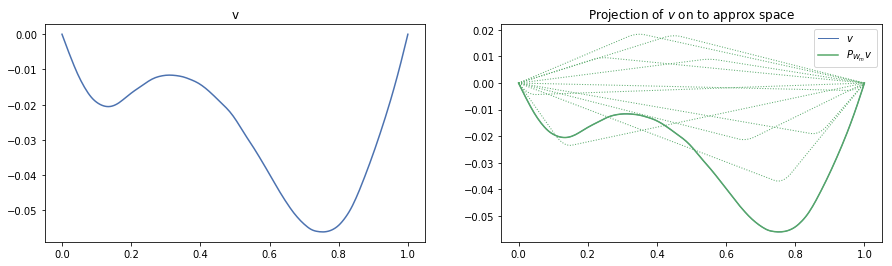

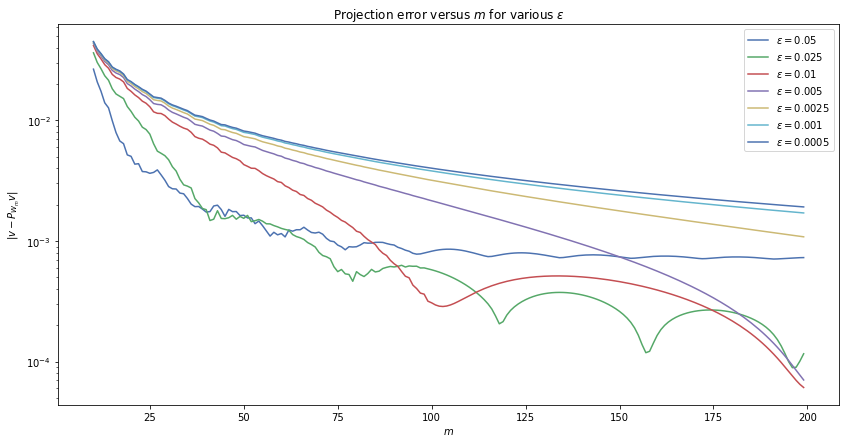

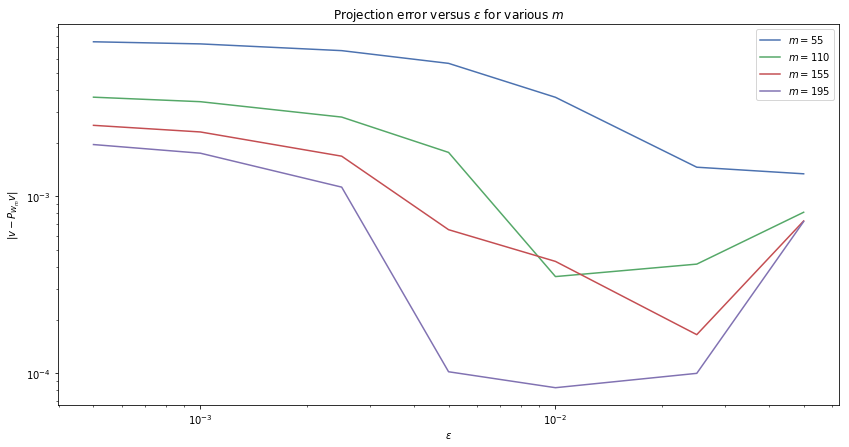

In [4]:
xs = np.arange(0.0, 1.005, 0.005)

sns.set_palette('deep')
cp = sns.color_palette()
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 2, 1, title='v')
plt.plot(xs, v.evaluate(xs), label=r'$v$')
ax = fig.add_subplot(1, 2, 2, title='Projection of $v$ on to approx space')
plt.plot(xs, v.evaluate(xs), label=r'$v$', linewidth=1)
plt.plot(xs, v_W.evaluate(xs), label=r'$P_{W_m} v$')
for i in range(Wm_plot.n):
    plt.plot(xs, (Wm_plot.vecs[i].evaluate(xs))*v_c[i], ':', linewidth=1, color=cp[1])
plt.legend()
plt.show()

# Compute projection error for various epsilon and m
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1, 1, 1, title=r'Projection error versus $m$ for various $\varepsilon$')
for i, epsilon in enumerate(epsilons):
    plt.semilogy(m_range, err[i,:], label=r'$\varepsilon={{{0}}}$'.format(epsilon))
ax.set(xlabel=r'$m$', ylabel=r'$\|v - P_{W_m} v\|$')
plt.legend()
plt.show()

# Pick some m and plot against epsilon...
ms = [55, 110, 155, 195]
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1, 1, 1, title=r'Projection error versus $\varepsilon$ for various $m$')
for i, m_sel in enumerate(ms):
    plt.loglog(epsilons, err[:,m_range.index(m_sel)], label=r'$m={{{0}}}$'.format(m_sel))
ax.set(xlabel=r'$\varepsilon$', ylabel=r'$\|v - P_{W_m} v\|$')
plt.legend()
plt.show()

### Now we try the Collective OMP and Worst-Case OMP algorithms for this problem

We look at the results both with $\varepsilon=0.01$ and $0.0025$ for both algorithms

In [7]:
N = 1e3

eps_0 = 0.09
eps_1 = 0.05
eps_2 = 0.01
eps_3 = 0.005

dictionaries = [pat.make_unif_dictionary(N), pat.make_unif_avg_dictionary(N, eps_0),\
                pat.make_unif_avg_dictionary(N, eps_1),\
                pat.make_unif_avg_dictionary(N, eps_2), pat.make_unif_avg_dictionary(N, eps_3)]

ns = [20,40]
np.random.seed(3)
#n = 20
m = 150
bs_comp = np.zeros((len(ns), m, len(dictionaries)))
bs_wcomp = np.zeros((len(ns), m, len(dictionaries)))
bs_rand = np.zeros((len(ns), m))
bs_avg = np.zeros((len(ns), m))

Vn = pat.make_sin_basis(ns[-1])
Wms_comp = []
Wms_wcomp = []
Wms_avg = []
Wms_rand = []

for k, dictionary in enumerate(dictionaries):
    for j, n in enumerate(ns):

        gbc = pat.CollectiveOMP(dictionary, Vn.subspace(slice(0,n)), verbose=True)
        Wm_comp = gbc.construct_to_m(m)
        Wms_comp.append(Wm_comp)
        Wm_comp_o = Wm_comp.orthonormalise()

        wcgbc = pat.WorstCaseOMP(dictionary, Vn.subspace(slice(0,n)), verbose=True)
        Wm_wcomp = wcgbc.construct_to_m(m)
        Wms_wcomp.append(Wm_wcomp)
        Wm_wcomp_o = Wm_wcomp.orthonormalise()

        # For efficiency it makes sense to compute the basis pair and the associated
        # cross-gramian only once, then sub sample it as we grow m...
        BP_comp_l = pat.BasisPair(Wm_comp_o, Vn.subspace(slice(0,n)))
        BP_wcomp_l = pat.BasisPair(Wm_wcomp_o, Vn.subspace(slice(0,n)))

        for i in range(n, m):
            BP_comp = BP_comp_l.subspace(Wm_indices=slice(0,i))
            bs_comp[j, i, k] = BP_comp.beta()

            BP_wcomp =  BP_wcomp_l.subspace(Wm_indices=slice(0,i))
            bs_wcomp[j, i, k] = BP_wcomp.beta()

i 	 || P_Vn (w - P_Wm w) ||
1 : 	 81 	 0.8571343821013426
2 : 	 959 	 0.8478519661242144
3 : 	 814 	 0.5929925737817036
4 : 	 244 	 0.5199125278326096
5 : 	 26 	 0.48416159219343224
6 : 	 901 	 0.3199274022393138
7 : 	 679 	 0.2985225653818852
8 : 	 374 	 0.26312642476426884
9 : 	 151 	 0.2620341816648731
10 : 	 750 	 0.14756995955527194
11 : 	 603 	 0.13852504744923777
12 : 	 448 	 0.12731472282743986
13 : 	 308 	 0.1230894105565528
14 : 	 862 	 0.10431733420279933
15 : 	 194 	 0.08760532948172653
16 : 	 983 	 0.07296362498788501
17 : 	 116 	 0.05720132587427976
18 : 	 930 	 0.049639312212446406
19 : 	 47 	 0.04564995435059706
20 : 	 564 	 0.03924205166611705
21 : 	 716 	 0.03479393843544868
22 : 	 641 	 0.034306212901091766
23 : 	 485 	 0.032058761270104964
24 : 	 412 	 0.030850765953742487
25 : 	 782 	 0.028143467877218494
26 : 	 276 	 0.02589831845260819
27 : 	 340 	 0.023928063825036986
28 : 	 219 	 0.012521433198424296
29 : 	 11 	 0.012498860576901388
30 : 	 838 	 0.0120823363786

90 : 	 61 	 0.00864260690752934
91 : 	 159 	 0.006106265866732241
92 : 	 789 	 0.006499483476644932
93 : 	 12 	 0.007516622169718309
94 : 	 818 	 0.005643232968780887
95 : 	 234 	 0.006209006582512458
96 : 	 267 	 0.005840197491789767
97 : 	 935 	 0.00592600290127375
98 : 	 952 	 0.006075354749429662
99 : 	 417 	 0.005064753645565551
100 : 	 546 	 0.00497763856211865
101 : 	 670 	 0.005034523321115744
102 : 	 29 	 0.004767705272884448
103 : 	 328 	 0.0044768699146102015
104 : 	 403 	 0.005082875054931296
105 : 	 642 	 0.004895029290965747
106 : 	 831 	 0.004435295335588348
107 : 	 205 	 0.004730571737459069
108 : 	 901 	 0.004790455354849052
109 : 	 83 	 0.005060423472026801
110 : 	 682 	 0.004753831010691725
111 : 	 506 	 0.004059391385082857
112 : 	 122 	 0.004682752626127024
113 : 	 804 	 0.004908607919784702
114 : 	 366 	 0.005500394996606636
115 : 	 656 	 0.00462031742466875
116 : 	 280 	 0.004901674721730809
117 : 	 304 	 0.00454275813225842
118 : 	 110 	 0.004676715770708301
119

30 : 	 328 	 0.13003944099350867
31 : 	 384 	 0.10526844107829396
32 : 	 259 	 0.11059424017049832
33 : 	 735 	 0.14772415350211562
34 : 	 468 	 0.09917130843364079
35 : 	 686 	 0.13868800612701776
36 : 	 519 	 0.11480995010354067
37 : 	 307 	 0.15300716328716824
38 : 	 564 	 0.12229360477344696
39 : 	 636 	 0.16977085473854905
40 : 	 426 	 0.08477682145527972
41 : 	 16 	 0.0799616244308099
42 : 	 483 	 0.06417252536230068
43 : 	 68 	 0.05153382341036987
44 : 	 879 	 0.060875353840895235
45 : 	 344 	 0.08059573500449246
46 : 	 774 	 0.062524095583998
47 : 	 170 	 0.06964594753162374
48 : 	 596 	 0.044028817757188705
49 : 	 94 	 0.050038319058295325
50 : 	 672 	 0.044456946084490745
51 : 	 196 	 0.051617447529264726
52 : 	 455 	 0.03732194986776331
53 : 	 826 	 0.05945730460000813
54 : 	 271 	 0.04235113485172454
55 : 	 980 	 0.16304251840139722
56 : 	 398 	 0.03441871675502502
57 : 	 723 	 0.04458167190277075
58 : 	 145 	 0.044208509502787194
59 : 	 647 	 0.03872123523130767
60 : 	 904

119 : 	 304 	 1.4214585312107408e-09
120 : 	 94 	 1.3429704292685238e-09
121 : 	 891 	 1.2601235435572921e-09
122 : 	 475 	 1.2180635440316854e-09
123 : 	 45 	 1.192767592097908e-09
124 : 	 187 	 1.1342373899391674e-09
125 : 	 705 	 1.0375864595810465e-09
126 : 	 554 	 1.022674731900404e-09
127 : 	 497 	 9.970465933571879e-10
128 : 	 210 	 1.1289431875409525e-09
129 : 	 293 	 1.3304436225207165e-09
130 : 	 696 	 9.243280346507267e-10
131 : 	 843 	 8.887764599072071e-10
132 : 	 631 	 8.743817769499818e-10
133 : 	 868 	 8.368096706809635e-10
134 : 	 998 	 7.782328578820939e-10
135 : 	 173 	 7.713891419237502e-10
136 : 	 201 	 6.641900776694432e-10
137 : 	 1 	 6.616478346991044e-10
138 : 	 100 	 1.0117075264042434e-09
139 : 	 880 	 5.834582540152773e-10
140 : 	 388 	 5.333620582249519e-10
141 : 	 508 	 5.076086486534979e-10
142 : 	 530 	 4.695892133101041e-10
143 : 	 519 	 5.398556881347588e-10
144 : 	 912 	 3.9351196809035296e-10
145 : 	 855 	 3.8338430777391976e-10
146 : 	 715 	 3.80275

53 : 	 970 	 1.529383198728102e-05
54 : 	 862 	 1.2342517179955494e-05
55 : 	 992 	 1.0229996359246474e-05
56 : 	 177 	 1.0037816743815695e-05
57 : 	 74 	 7.961108283488544e-06
58 : 	 31 	 7.67933719347763e-06
59 : 	 927 	 4.972564707600903e-06
60 : 	 585 	 4.281508408700802e-06
61 : 	 123 	 3.7188500881180644e-06
62 : 	 949 	 3.45878619776746e-06
63 : 	 886 	 3.3821917543942396e-06
64 : 	 52 	 3.2734419456091186e-06
65 : 	 395 	 2.9385506771843316e-06
66 : 	 905 	 2.3643504139178646e-06
67 : 	 352 	 2.299443354390031e-06
68 : 	 740 	 1.7443330301219845e-06
69 : 	 502 	 1.7134204213542654e-06
70 : 	 373 	 1.5974646399433062e-06
71 : 	 3 	 1.5748847558286788e-06
72 : 	 438 	 1.2958158356179227e-06
73 : 	 562 	 1.3374018742398386e-06
74 : 	 541 	 1.082055528305585e-06
75 : 	 234 	 1.0111676491536886e-06
76 : 	 759 	 9.65437834173698e-07
77 : 	 996 	 8.945970571700402e-07
78 : 	 104 	 8.303737616676493e-07
79 : 	 312 	 8.90828813198963e-07
80 : 	 293 	 8.262645498343007e-07
81 : 	 459 	 7

136 : 	 93 	 2.1977243907910968e-05
137 : 	 102 	 2.069251635535119e-05
138 : 	 2 	 1.981637019490487e-05
139 : 	 402 	 1.9492526282431374e-05
140 : 	 24 	 2.0636791360754796e-05
141 : 	 497 	 2.0640869631291504e-05
142 : 	 867 	 1.9715645863132416e-05
143 : 	 68 	 1.7821662973408327e-05
144 : 	 99 	 1.686109685112544e-05
145 : 	 397 	 1.629546371770027e-05
146 : 	 494 	 1.8953127283272294e-05
147 : 	 16 	 1.6283744808770722e-05
148 : 	 933 	 1.5457431423723214e-05
149 : 	 107 	 1.4521329705529499e-05


Done!
i 	 || P_Vn (w - P_Wm w) ||
1 : 	 985 	 0.945397728886336
2 : 	 13 	 0.9357489860537714
3 : 	 822 	 0.616855764896386
4 : 	 169 	 0.585435088568317
5 : 	 662 	 0.31647852523061687
6 : 	 917 	 0.284327346791042
7 : 	 308 	 0.2803292434272113
8 : 	 78 	 0.27459482335457064
9 : 	 569 	 0.1336261106969678
10 : 	 745 	 0.1326127139938373
11 : 	 389 	 0.11459050767502875
12 : 	 235 	 0.10920547486957276
13 : 	 873 	 0.06701439327717652
14 : 	 120 	 0.062167094233295965
15 : 	 522 	 0.03

72 : 	 638 	 9.301267392708423e-05
73 : 	 144 	 8.526847049046202e-05
74 : 	 620 	 7.097098478819203e-05
75 : 	 19 	 6.344489380175067e-05
76 : 	 983 	 5.99109953929311e-05
77 : 	 128 	 6.39913411213805e-05
78 : 	 877 	 6.417192818519712e-05
79 : 	 783 	 6.24453725469043e-05
80 : 	 431 	 7.019816282297087e-05
81 : 	 42 	 5.675313970276985e-05
82 : 	 850 	 5.596160790938276e-05
83 : 	 747 	 5.245636958142556e-05
84 : 	 907 	 7.476781059010534e-05
85 : 	 7 	 5.4455801110186997e-05
86 : 	 767 	 6.28019382956646e-05
87 : 	 892 	 4.3556894551953496e-05
88 : 	 230 	 5.078878514215568e-05
89 : 	 360 	 4.571403347922165e-05
90 : 	 80 	 4.504460763081475e-05
91 : 	 569 	 3.910729944427843e-05
92 : 	 303 	 3.790865633332245e-05
93 : 	 548 	 3.737446468590755e-05
94 : 	 662 	 2.8085232488345158e-05
95 : 	 215 	 3.5146934993846024e-05
96 : 	 993 	 3.109928980576937e-05
97 : 	 402 	 2.584183001685253e-05
98 : 	 923 	 2.773971527675334e-05
99 : 	 334 	 2.3771665922978774e-05
100 : 	 677 	 3.89443843

5 : 	 691 	 1.862370122452393e-15
6 : 	 38 	 1.2440270247258935e-15
7 : 	 803 	 9.851589284639882e-16
8 : 	 959 	 9.31339775271915e-16
9 : 	 247 	 2.1090776410787018e-15
10 : 	 375 	 3.167601800046954e-15
11 : 	 95 	 1.3538072523282463e-15
12 : 	 324 	 1.1284934918682331e-15
13 : 	 641 	 9.687388082178014e-16
14 : 	 558 	 1.3915966265946251e-15
15 : 	 437 	 1.3798751060405558e-15
16 : 	 0 	 1.5128640727167703e-15
17 : 	 747 	 1.5342119865164204e-15
18 : 	 935 	 8.104783302931225e-16
19 : 	 857 	 2.6988005612068656e-15
20 : 	 280 	 2.156825457597134e-15
21 : 	 602 	 1.5885212813311383e-15
22 : 	 188 	 2.9339193785109563e-15
23 : 	 526 	 1.008272818640699e-15
24 : 	 404 	 1.0134380174431489e-15
25 : 	 882 	 1.0447355593172603e-15
26 : 	 68 	 1.3158120981675073e-15
27 : 	 717 	 1.4081068976803088e-15
28 : 	 219 	 1.610782651913803e-15
29 : 	 468 	 1.2988860028066894e-15
30 : 	 827 	 1.4122460706472812e-15
31 : 	 775 	 1.2064075729047516e-15
32 : 	 120 	 1.640527780361324e-15
33 : 	 348 	 

90 : 	 972 	 2.275621447599225e-05
91 : 	 27 	 2.2682332210201972e-05
92 : 	 56 	 1.8439819126789893e-05
93 : 	 744 	 1.6618284062977184e-05
94 : 	 913 	 1.4681476381778154e-05
95 : 	 87 	 1.3745157507897758e-05
96 : 	 42 	 1.3612508648695731e-05
97 : 	 809 	 1.1711595013854789e-05
98 : 	 72 	 1.14652623533655e-05
99 : 	 957 	 1.1298043466752476e-05
100 : 	 943 	 1.0310221798059102e-05
101 : 	 928 	 1.1212978981226448e-05
102 : 	 761 	 1.0268928830522026e-05
103 : 	 777 	 1.2830041488011525e-05
104 : 	 793 	 1.3239609081353414e-05
105 : 	 984 	 3.2667407695462668e-06
106 : 	 15 	 3.2585015577128035e-06
107 : 	 179 	 1.8253430106155391e-06
108 : 	 142 	 1.2985038327504325e-06
109 : 	 994 	 7.353072702326002e-07
110 : 	 5 	 7.325228697672527e-07
111 : 	 822 	 5.799232019401873e-07
112 : 	 166 	 4.779051800652499e-07
113 : 	 154 	 5.014955572508632e-07
114 : 	 835 	 4.0674221079126575e-07
115 : 	 847 	 3.3482484485027716e-07
116 : 	 859 	 4.603295141226128e-07
117 : 	 130 	 2.431990326210

28 : 	 420 	 0.04317473011528421
29 : 	 72 	 0.04079037017409791
30 : 	 928 	 0.0376839053757079
31 : 	 539 	 0.0374338737516371
32 : 	 998 	 0.03736732085049568
33 : 	 1 	 0.03736079652129438
34 : 	 364 	 0.03717011626253492
35 : 	 594 	 0.03514796868372659
36 : 	 313 	 0.03342480624284242
37 : 	 645 	 0.030555080896943698
38 : 	 693 	 0.029658138223230823
39 : 	 267 	 0.023767075778931935
40 : 	 737 	 0.022761941635321286
41 : 	 777 	 0.020055418603400575
42 : 	 190 	 0.019783272349074493
43 : 	 227 	 0.01811429676582986
44 : 	 813 	 0.014977778309492372
45 : 	 155 	 0.013655048822317103
46 : 	 846 	 0.010313909156616008
47 : 	 465 	 0.0068836887672559886
48 : 	 497 	 0.005654317482435167
49 : 	 435 	 0.005348146879037921
50 : 	 405 	 0.004487487400026479
51 : 	 126 	 0.004185240729391842
52 : 	 553 	 0.004184036918723676
53 : 	 874 	 0.0041523736297432124
54 : 	 44 	 0.003286782853270511
55 : 	 581 	 0.0032152567812244854
56 : 	 955 	 0.0032072217493759585
57 : 	 377 	 0.00320177963

118 : 	 174 	 0.0021273997724743435
119 : 	 443 	 0.0020354062640336873
120 : 	 937 	 0.00391050283216568
121 : 	 901 	 0.001591587802124407
122 : 	 672 	 0.0019362245715576626
123 : 	 950 	 0.0017844225395741986
124 : 	 748 	 0.0019151130769350655
125 : 	 61 	 0.003960063981548911
126 : 	 557 	 0.001571414989040329
127 : 	 297 	 0.001632882517175506
128 : 	 403 	 0.0011606269751220505
129 : 	 647 	 0.0011350111037327915
130 : 	 125 	 0.0012922473712868032
131 : 	 999 	 0.0011342844794788448
132 : 	 569 	 0.0009078107305459729
133 : 	 759 	 0.001461376278391907
134 : 	 35 	 0.0011356395047588674
135 : 	 215 	 0.0010217932647707297
136 : 	 285 	 0.0008155233434642695
137 : 	 989 	 0.0011316158801778775
138 : 	 707 	 0.0011273562972941714
139 : 	 913 	 0.0012462157261927953
140 : 	 163 	 0.0011172300077409714
141 : 	 532 	 0.0007212956219284083
142 : 	 237 	 0.0007519519389790827
143 : 	 809 	 0.001285847586709979
144 : 	 226 	 0.0007798202510966579
145 : 	 392 	 0.0006645045209422787
14

56 : 	 813 	 0.01819086697528305
57 : 	 126 	 0.016357517669343402
58 : 	 101 	 0.020184749168059027
59 : 	 539 	 0.01690669912976918
60 : 	 733 	 0.01830642922168775
61 : 	 4 	 0.017822995132989156
62 : 	 360 	 0.014391112021412064
63 : 	 972 	 0.015709293238368366
64 : 	 24 	 0.01799526412194513
65 : 	 286 	 0.013781734218317715
66 : 	 758 	 0.01933289763616039
67 : 	 151 	 0.025598621839518138
68 : 	 896 	 0.012340883974442246
69 : 	 311 	 0.0115042711394992
70 : 	 176 	 0.015796390671092536
71 : 	 919 	 0.013702240873857158
72 : 	 78 	 0.010967773901895225
73 : 	 709 	 0.012363977489219302
74 : 	 687 	 0.013004102144149876
75 : 	 490 	 0.00712205887491664
76 : 	 577 	 0.006316954963251575
77 : 	 440 	 0.00657938123777238
78 : 	 613 	 0.005002090548419089
79 : 	 473 	 0.005311613007663793
80 : 	 777 	 0.005200969494744495
81 : 	 595 	 0.007286657433509328
82 : 	 987 	 0.004811260880838886
83 : 	 937 	 0.004128019322583443
84 : 	 59 	 0.006848521629949256
85 : 	 561 	 0.0040520455830

144 : 	 614 	 5.430603533443809e-05
145 : 	 435 	 5.294335315713211e-05
146 : 	 659 	 5.2831569926393564e-05
147 : 	 459 	 5.157181827024069e-05
148 : 	 670 	 5.0181048711600156e-05
149 : 	 681 	 5.423368511376598e-05


Done!
i 	 || P_Vn (w - P_Wm w) ||
1 : 	 6 	 0.1114724080372843
2 : 	 32 	 0.16691354872711475
3 : 	 863 	 0.22230652516263483
4 : 	 57 	 0.14908665505083893
5 : 	 712 	 0.20708460273434504
6 : 	 211 	 0.15437877812180414
7 : 	 613 	 0.12413999223329093
8 : 	 964 	 0.1947308720676019
9 : 	 788 	 0.16592206323156863
10 : 	 157 	 0.13962133726435372
11 : 	 82 	 0.13623871355869718
12 : 	 409 	 0.16923500006570757
13 : 	 283 	 0.15085732776767657
14 : 	 661 	 0.12398786541699496
15 : 	 991 	 0.12868649616786032
16 : 	 360 	 0.1534870219056885
17 : 	 542 	 0.1319325040351331
18 : 	 895 	 0.13375305606568003
19 : 	 445 	 0.14861590223389187
20 : 	 131 	 0.1327551920563286
21 : 	 939 	 0.1610407137140874
22 : 	 835 	 0.12693384456879336
23 : 	 237 	 0.11621189188087874
24 : 	 

In [8]:
for j, n in enumerate(ns):

    Wm_rand = pat.make_random_avg_basis(m, epsilon=1.0e-2)
    Wms_rand.append(Wm_rand)
    Wm_rand_o = Wm_rand.orthonormalise()

    # For efficiency it makes sense to compute the basis pair and the associated
    # cross-gramian only once, then sub sample it as we grow m...
    BP_rand_l = pat.BasisPair(Wm_rand_o, Vn.subspace(slice(0,n)))

    for i in range(n, m):
        BP_rand = BP_rand_l.subspace(Wm_indices=slice(0,i))
        bs_rand[j, i] = BP_rand.beta()

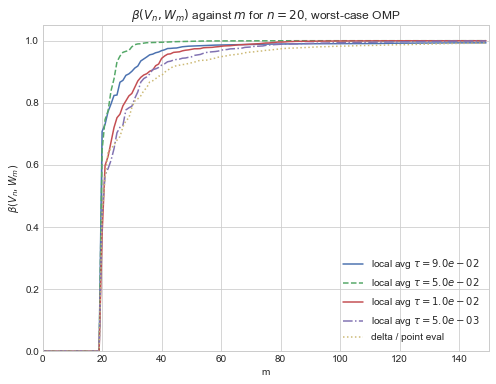

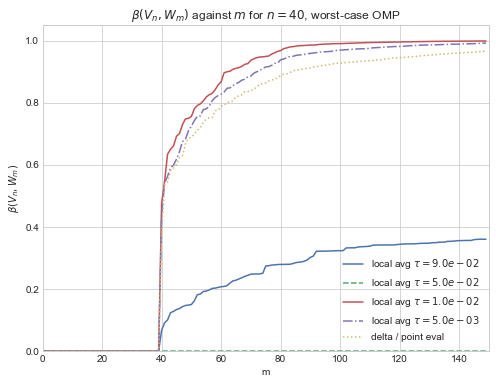

In [9]:
dict_label = [r'delta / point eval', r'local avg $\tau={{{0:0.1e}}}$'.format(eps_0), \
              r'local avg $\tau={{{0:0.1e}}}$'.format(eps_1), \
              r'local avg $\tau={{{0:0.1e}}}$'.format(eps_2), \
              r'local avg $\tau={{{0:0.1e}}}$'.format(eps_3)]

line_style = ['-', '--', '-', '-.', '-', ':']

sns.set_palette("deep")
cp = sns.color_palette()
#sns.set_palette(sns.light_palette("red", reverse=True))
sns.set_palette("deep")

sns.set_style('whitegrid')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n=20$, worst-case OMP')

for k, dictionary in enumerate(dictionaries[1:]):
    plt.plot(range(m), bs_wcomp[0, :, k+1], line_style[k], label=r'{0}'.format(dict_label[k+1]))
plt.plot(range(m), bs_wcomp[0, :, 0], line_style[-1], label=r'{0}'.format(dict_label[0]))
#plt.plot(range(m), bs_rand[0, :], '-.', label=r'Random Wm'.format(n), color=cp[4])

ax.set(xlabel='m', ylabel=r'$\beta(V_n, W_m)$', xlim=[0,150], ylim=[0.,1.05])
plt.legend(loc=4)
plt.savefig('WCOMPAvgVsDelta_20.pdf')
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n=40$, worst-case OMP')

for k, dictionary in enumerate(dictionaries[1:]):
    plt.plot(range(m), bs_wcomp[1, :, k+1], line_style[k], label=r'{0}'.format(dict_label[k+1]))
plt.plot(range(m), bs_wcomp[1, :, 0], line_style[-1], label=r'{0}'.format(dict_label[0]))
#plt.plot(range(m), bs_rand[1, :], '-.', label=r'Random Wm'.format(n), color=cp[4])

ax.set(xlabel='m', ylabel=r'$\beta(V_n, W_m)$', xlim=[0,150], ylim=[0.,1.05])
plt.legend(loc=4)
plt.savefig('WCOMPAvgVsDelta_40.pdf')
plt.show()

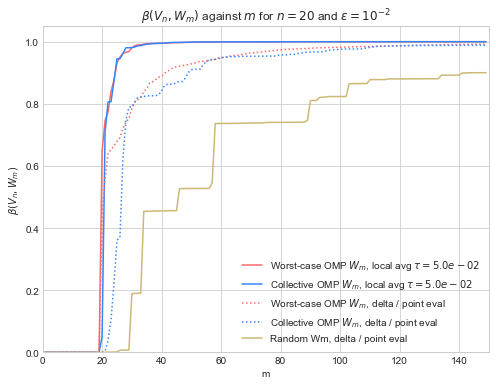

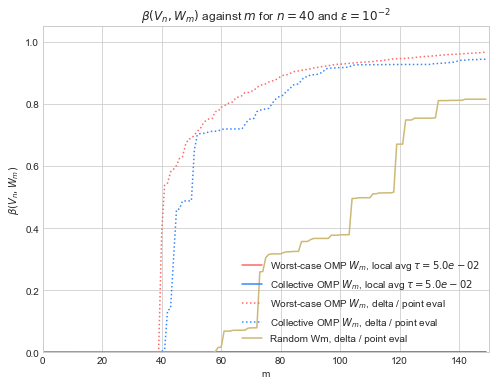

In [10]:
line_style = ['-', '--', '-.', ':']

sns.set_palette("deep")
cp = sns.color_palette()
bl = (51/255, 133/255, 255/255)
re = (255/255, 102/255, 102/255)

sns.set_style('whitegrid')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n=20$ and $\varepsilon=10^{-2}$')

k = 2
plt.plot(range(m), bs_wcomp[0, :, k], label=r'Worst-case OMP $W_m$, {0}'.format(dict_label[k]), color=re)
plt.plot(range(m), bs_comp[0, :, k], label=r'Collective OMP $W_m$, {0}'.format(dict_label[k]), color=bl)
k = 0
plt.plot(range(m), bs_wcomp[0, :, k], ':', label=r'Worst-case OMP $W_m$, {0}'.format(dict_label[k]), color=re)
plt.plot(range(m), bs_comp[0, :, k], ':', label=r'Collective OMP $W_m$, {0}'.format(dict_label[k]), color=bl)
plt.plot(range(m), bs_rand[0, :], label=r'Random Wm, {0}'.format(dict_label[k]), color=cp[4])

ax.set(xlabel='m', ylabel=r'$\beta(V_n, W_m)$', xlim=[0,150], ylim=[0.,1.05])
plt.legend(loc=4)
plt.savefig('COMPvsWCOMPAvg_20.pdf')
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n=40$ and $\varepsilon=10^{-2}$')

k = 2
plt.plot(range(m), bs_wcomp[1, :, k], label=r'Worst-case OMP $W_m$, {0}'.format(dict_label[k]), color=re)
plt.plot(range(m), bs_comp[1, :, k], label=r'Collective OMP $W_m$, {0}'.format(dict_label[k]), color=bl)
k = 0
plt.plot(range(m), bs_wcomp[1, :, k], ':', label=r'Worst-case OMP $W_m$, {0}'.format(dict_label[k]), color=re)
plt.plot(range(m), bs_comp[1, :, k], ':', label=r'Collective OMP $W_m$, {0}'.format(dict_label[k]), color=bl)

plt.plot(range(m), bs_rand[1, :], label=r'Random Wm, {0}'.format(dict_label[k]), color=cp[4])

ax.set(xlabel='m', ylabel=r'$\beta(V_n, W_m)$', xlim=[0,150], ylim=[0.,1.05])
plt.legend(loc=4)
plt.savefig('COMPvsWCOMPAvg_40.pdf')
plt.show()

### Plot the locations of the local averages chosen for $W_m$

This is a similar plot to that we saw in ```01_omp_collective.ipynb```, where the location of the local averages that is picked by that step is also shown (only possible because the range of $\beta$ is $[0,1]$, and the domain happens to also be $[0,1]$.

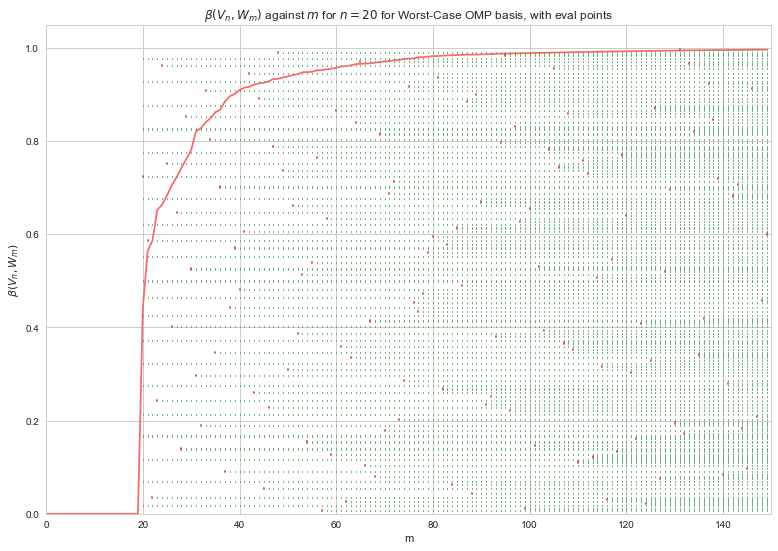

In [9]:
wc = 3 # The "width choice" in this case corresponds to 2.5e-3
nc = 0 # n choice 0 means 20
n = ns[nc]

Wm_wcomp = Wms_wcomp[2*wc + nc]
b_wcomp = bs_wcomp[nc,:,wc]
Wm_comp = Wms_comp[2*wc + nc]
b_comp = bs_comp[nc,:,wc]

# Plot the evaluation points in the Wm basss 
Wm_points = np.array([vec.params_array(0).flatten() for vec in Wm_wcomp.vecs])

line_style = ['-', '--', '-.', ':']

sns.set_palette("deep")
cp = sns.color_palette()
bl = (51/255, 133/255, 255/255)
re = (255/255, 102/255, 102/255)

sns.set_style('whitegrid')

axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n={{{0}}}$ for Worst-Case OMP basis, with eval points'.format(n))
ax.set(xlabel=r'$m$', ylabel=r'$\beta(V_n, W_m)$ and point locations')

plt.plot(range(m), b_wcomp, color=re, label=r'$\beta(V_n, W_m)$ for OMP $W_m$')

for k in range(20,m):

    for j in range(k-1):
        plt.plot(k * np.ones(2), Wm_points[j,:], color=cp[1], label='eval intervals', linewidth=1)
    plt.plot(k * np.ones(2), Wm_points[k-1,:], color=cp[2], markersize=6, label='New eval point')

ax.set(xlabel='m', ylabel=r'$\beta(V_n, W_m)$', xlim=[0,150], ylim=[0.,1.05])
plt.savefig('WCOMPAvgLocations_{0}.pdf'.format(n))
plt.show()

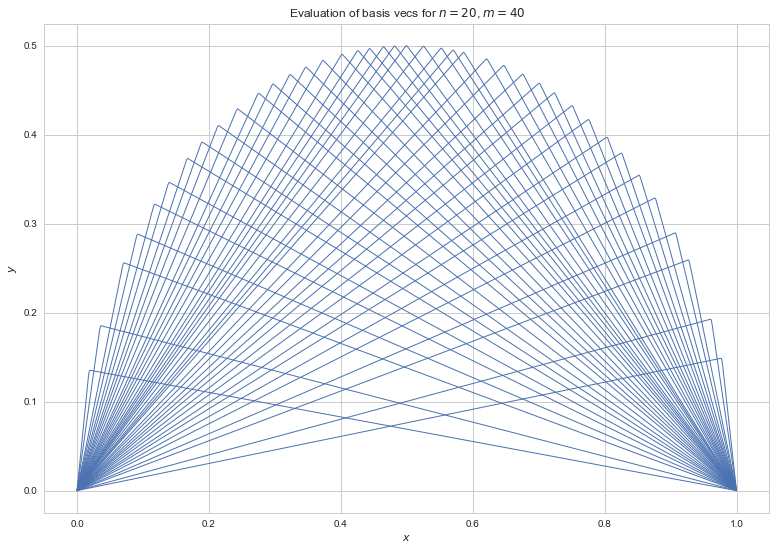

In [57]:
# Ok, so that's a more or less incomprehensible chart, what about just taking one step and checking it out?
k = 40
xs = np.arange(0,1.001,0.001)

axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title=r'Evaluation of basis vecs for $n={{{0}}}$, $m={{{1}}}$'.format(n,k))
ax.set(xlabel=r'$x$', ylabel=r'$y$')

for j in range(k):
    plt.plot(xs, Wm_wcomp.vecs[j].evaluate(xs), color=cp[0], linewidth=1)

plt.savefig('WCOMPAvgEvaluations_{0}_{1}.pdf'.format(n, k))
plt.show()